# Lecture 04: Anomaly Detection

## Learning Objectives
By the end of this lecture, you will be able to:
- Understand what anomalies are and why they matter
- Apply statistical methods for anomaly detection
- Use Isolation Forest for outlier detection
- Compare different anomaly detection approaches
- Evaluate anomaly detection results

**Prerequisites:** Basic statistics, understanding of distributions

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
print('✓ Ready for Anomaly Detection!')

✓ Ready for Anomaly Detection!


## 1. What are Anomalies?

### Definition

**Anomalies (Outliers):** Data points that deviate significantly from the normal pattern

### Types of Anomalies

1. **Point Anomalies:** Individual data points that are unusual
2. **Contextual Anomalies:** Unusual in specific context (e.g., high temperature in winter)
3. **Collective Anomalies:** Collection of points that are unusual together

### Real-World Examples

- **Fraud Detection:** Unusual credit card transactions
- **Manufacturing:** Defective products
- **Network Security:** Intrusion attempts
- **Healthcare:** Unusual patient vitals
- **Predictive Maintenance:** Equipment failure signals

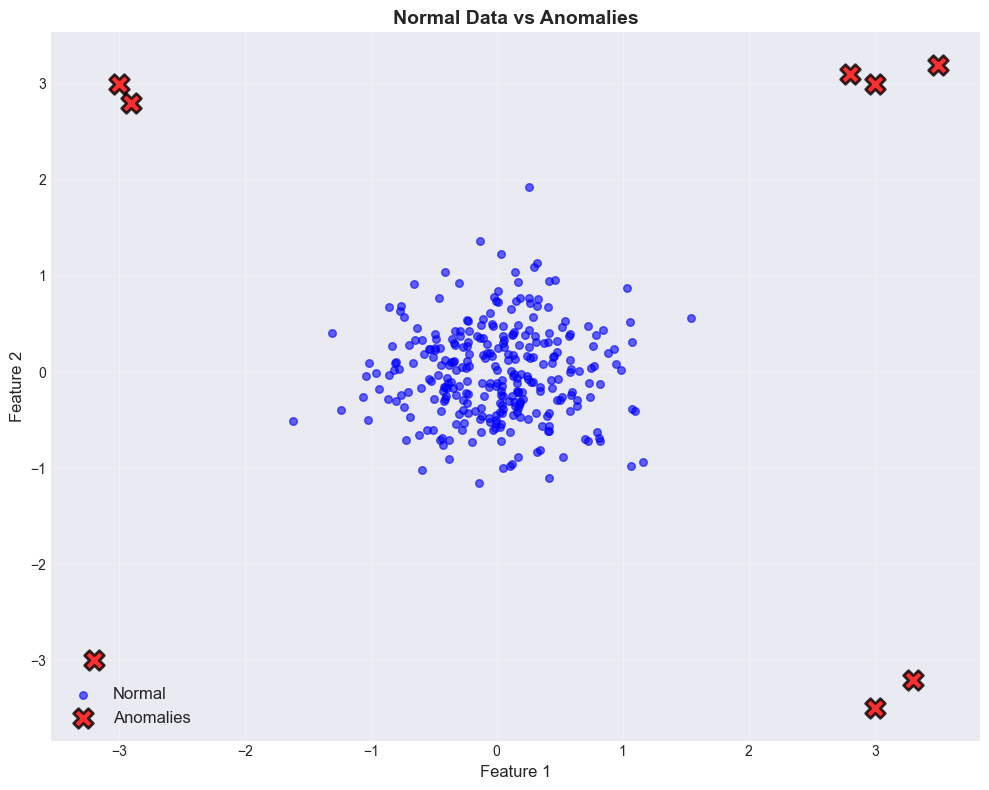


Dataset:
  Normal points: 300
  Anomalies: 8
  Contamination: 2.6%


In [2]:
# Generate data with anomalies
np.random.seed(42)

# Normal data
X_normal = np.random.randn(300, 2) * 0.5 + [0, 0]

# Anomalies
X_anomalies = np.array([
    [3, 3], [3.5, 3.2], [-3, 3], [-3.2, -3], [3, -3.5],
    [2.8, 3.1], [-2.9, 2.8], [3.3, -3.2]
])

# Combine
X_combined = np.vstack([X_normal, X_anomalies])
y_true = np.array([0]*len(X_normal) + [1]*len(X_anomalies))  # 0=normal, 1=anomaly

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_normal[:, 0], X_normal[:, 1], c='blue', s=30, alpha=0.6, label='Normal')
ax.scatter(X_anomalies[:, 0], X_anomalies[:, 1], c='red', s=200, alpha=0.8, 
          marker='X', edgecolors='black', linewidth=2, label='Anomalies')
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Normal Data vs Anomalies', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDataset:")
print(f"  Normal points: {len(X_normal)}")
print(f"  Anomalies: {len(X_anomalies)}")
print(f"  Contamination: {len(X_anomalies)/len(X_combined):.1%}")

## 2. Statistical Methods

### Z-Score Method

**Idea:** Points far from mean (in standard deviations) are anomalies

**Formula:** 
```
z = (x - μ) / σ
```

**Threshold:** |z| > 3 → anomaly

**Assumption:** Data follows normal distribution

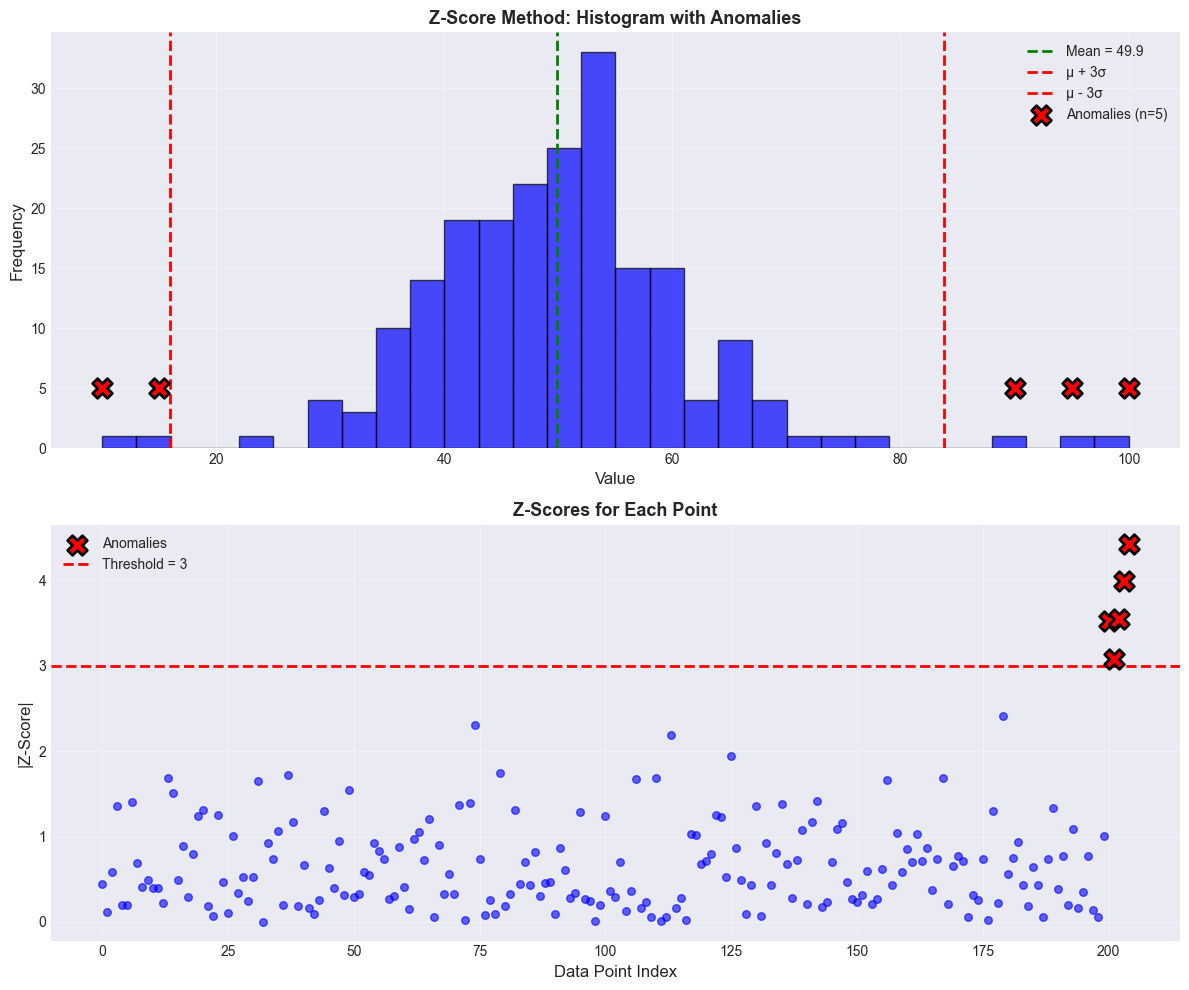


Z-Score Method Results:
  Mean: 49.89
  Std: 11.31
  Threshold: |z| > 3
  Anomalies detected: 5
  Anomalous values: [ 10.  15.  90.  95. 100.]


In [3]:
# Z-Score Method (1D example)
np.random.seed(42)

# Generate 1D data with outliers
data_normal_1d = np.random.randn(200) * 10 + 50
data_anomalies_1d = np.array([10, 15, 90, 95, 100])
data_1d = np.concatenate([data_normal_1d, data_anomalies_1d])

# Compute Z-scores
mean = np.mean(data_1d)
std = np.std(data_1d)
z_scores = np.abs((data_1d - mean) / std)

# Threshold: |z| > 3
threshold = 3
anomalies_mask = z_scores > threshold

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram with threshold
axes[0].hist(data_1d, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(mean, color='green', linestyle='--', linewidth=2, label=f'Mean = {mean:.1f}')
axes[0].axvline(mean + 3*std, color='red', linestyle='--', linewidth=2, label=f'μ + 3σ')
axes[0].axvline(mean - 3*std, color='red', linestyle='--', linewidth=2, label=f'μ - 3σ')
axes[0].scatter(data_1d[anomalies_mask], [5]*sum(anomalies_mask), 
               c='red', s=200, marker='X', edgecolors='black', linewidth=2,
               label=f'Anomalies (n={sum(anomalies_mask)})', zorder=5)
axes[0].set_xlabel('Value', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Z-Score Method: Histogram with Anomalies', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Z-scores
axes[1].scatter(range(len(z_scores)), z_scores, c='blue', s=30, alpha=0.6)
axes[1].scatter(np.where(anomalies_mask)[0], z_scores[anomalies_mask],
               c='red', s=200, marker='X', edgecolors='black', linewidth=2,
               label='Anomalies', zorder=5)
axes[1].axhline(threshold, color='red', linestyle='--', linewidth=2, 
               label=f'Threshold = {threshold}')
axes[1].set_xlabel('Data Point Index', fontsize=12)
axes[1].set_ylabel('|Z-Score|', fontsize=12)
axes[1].set_title('Z-Scores for Each Point', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nZ-Score Method Results:")
print(f"  Mean: {mean:.2f}")
print(f"  Std: {std:.2f}")
print(f"  Threshold: |z| > {threshold}")
print(f"  Anomalies detected: {sum(anomalies_mask)}")
print(f"  Anomalous values: {data_1d[anomalies_mask]}")

### IQR Method (Interquartile Range)

**Idea:** Points outside [Q1 - 1.5×IQR, Q3 + 1.5×IQR] are anomalies

**Where:**
- Q1 = 25th percentile
- Q3 = 75th percentile
- IQR = Q3 - Q1

**Advantage:** Robust to non-normal distributions

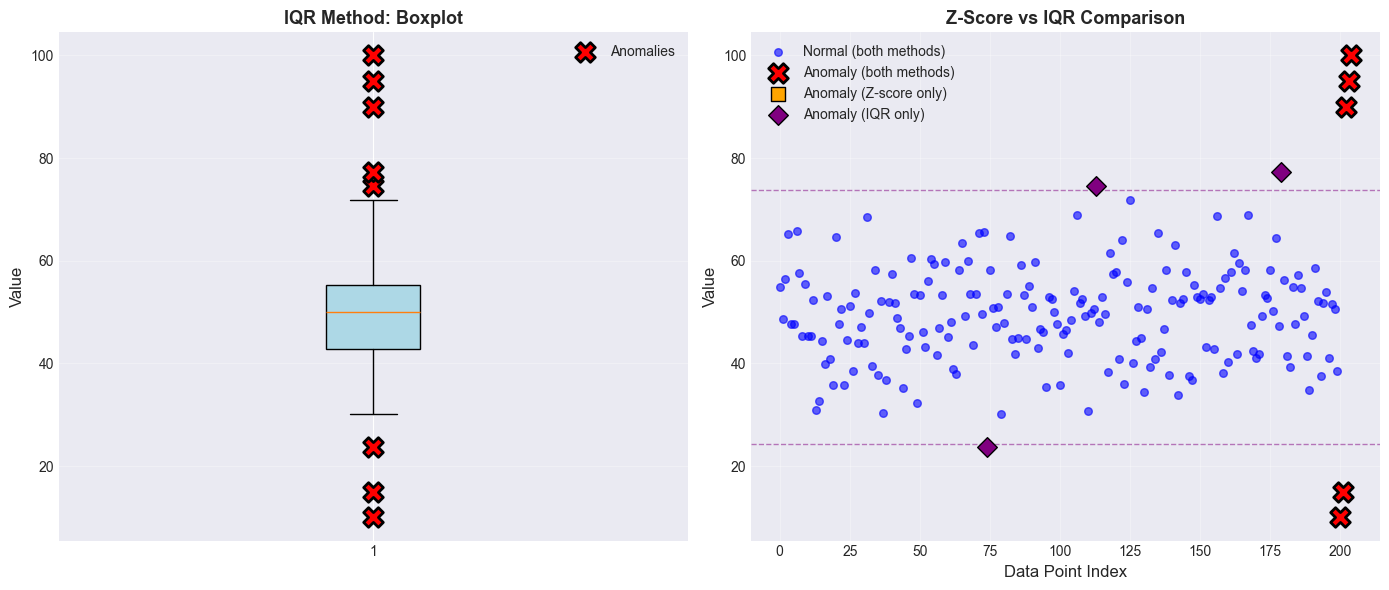


IQR Method Results:
  Q1: 42.86
  Q3: 55.22
  IQR: 12.36
  Lower bound: 24.31
  Upper bound: 73.76
  Anomalies detected: 8

Comparison:
  Both methods agree: 5 anomalies
  Z-score only: 0
  IQR only: 3


In [4]:
# IQR Method
Q1 = np.percentile(data_1d, 25)
Q3 = np.percentile(data_1d, 75)
IQR = Q3 - Q1

# Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect anomalies
anomalies_iqr = (data_1d < lower_bound) | (data_1d > upper_bound)

# Visualize with boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
bp = axes[0].boxplot(data_1d, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0].scatter([1]*sum(anomalies_iqr), data_1d[anomalies_iqr],
               c='red', s=200, marker='X', edgecolors='black', linewidth=2,
               label='Anomalies', zorder=5)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('IQR Method: Boxplot', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Comparison: Z-Score vs IQR
x_pos = np.arange(len(data_1d))
axes[1].scatter(x_pos[~anomalies_mask & ~anomalies_iqr], 
               data_1d[~anomalies_mask & ~anomalies_iqr],
               c='blue', s=30, alpha=0.6, label='Normal (both methods)')
axes[1].scatter(x_pos[anomalies_mask & anomalies_iqr], 
               data_1d[anomalies_mask & anomalies_iqr],
               c='red', s=200, marker='X', edgecolors='black', linewidth=2,
               label='Anomaly (both methods)', zorder=5)
axes[1].scatter(x_pos[anomalies_mask & ~anomalies_iqr], 
               data_1d[anomalies_mask & ~anomalies_iqr],
               c='orange', s=100, marker='s', edgecolors='black', linewidth=1,
               label='Anomaly (Z-score only)', zorder=4)
axes[1].scatter(x_pos[~anomalies_mask & anomalies_iqr], 
               data_1d[~anomalies_mask & anomalies_iqr],
               c='purple', s=100, marker='D', edgecolors='black', linewidth=1,
               label='Anomaly (IQR only)', zorder=4)
axes[1].axhline(upper_bound, color='purple', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(lower_bound, color='purple', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Data Point Index', fontsize=12)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_title('Z-Score vs IQR Comparison', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nIQR Method Results:")
print(f"  Q1: {Q1:.2f}")
print(f"  Q3: {Q3:.2f}")
print(f"  IQR: {IQR:.2f}")
print(f"  Lower bound: {lower_bound:.2f}")
print(f"  Upper bound: {upper_bound:.2f}")
print(f"  Anomalies detected: {sum(anomalies_iqr)}")
print(f"\nComparison:")
print(f"  Both methods agree: {sum(anomalies_mask & anomalies_iqr)} anomalies")
print(f"  Z-score only: {sum(anomalies_mask & ~anomalies_iqr)}")
print(f"  IQR only: {sum(~anomalies_mask & anomalies_iqr)}")

## 3. Isolation Forest

### Core Idea

**Key Insight:** Anomalies are easier to isolate (separate) than normal points

**Algorithm:**
1. Build random trees by randomly selecting features and split values
2. Isolate each point by recursively splitting
3. Anomalies require fewer splits (shorter path)
4. Average path length across trees → anomaly score

### Advantages

✅ **No assumptions** about data distribution

✅ **Fast and scalable**

✅ **Works in high dimensions**

✅ **Handles complex patterns**

### Main Parameter

- **contamination:** Expected proportion of anomalies (e.g., 0.1 = 10%)

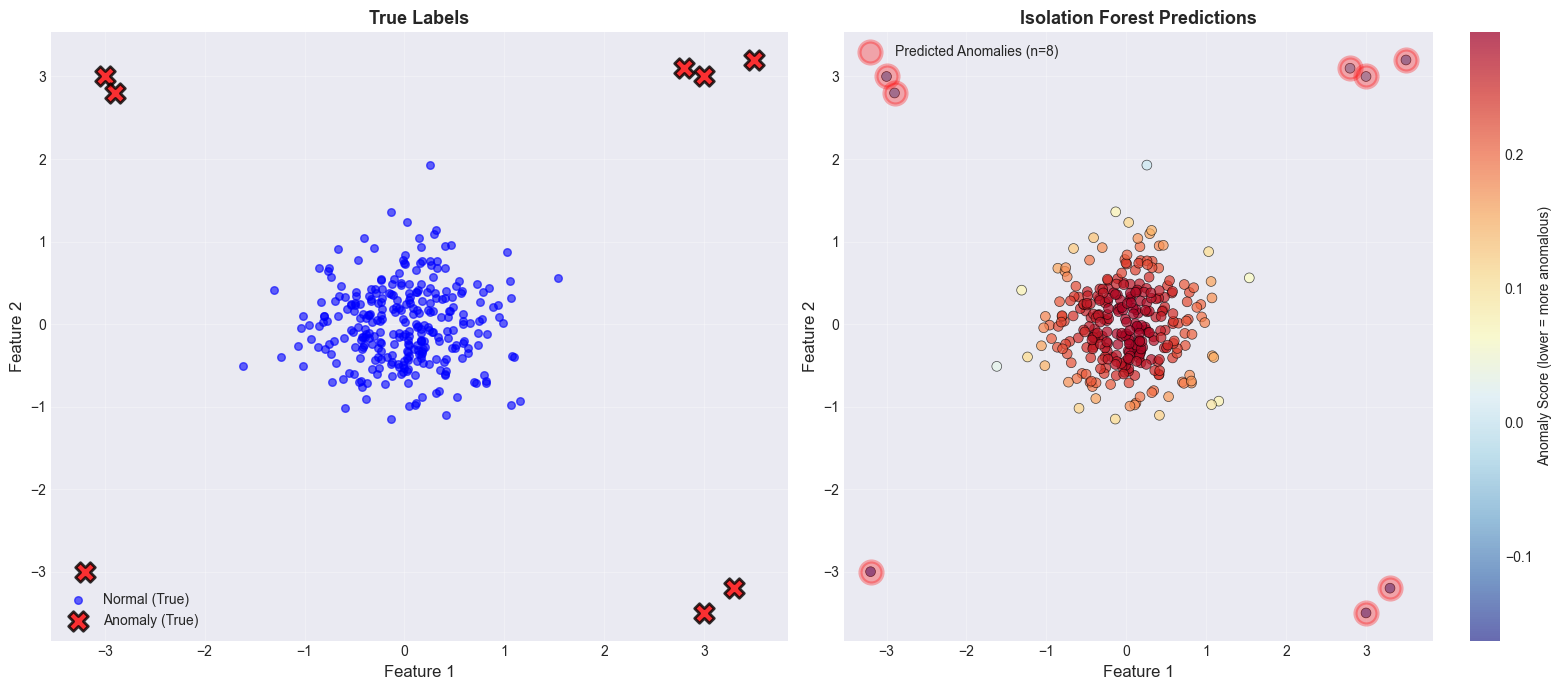


Isolation Forest Results:
  True anomalies: 8
  Predicted anomalies: 8
  Correctly identified: 8


In [5]:
# Isolation Forest on 2D data
# Scale data first
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=len(X_anomalies)/len(X_combined),
                              random_state=42, n_estimators=100)
y_pred = iso_forest.fit_predict(X_combined_scaled)

# Convert predictions: 1=normal, -1=anomaly
y_pred_binary = (y_pred == -1).astype(int)  # Convert to 0=normal, 1=anomaly

# Get anomaly scores
scores = iso_forest.decision_function(X_combined_scaled)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# True labels
axes[0].scatter(X_combined[y_true==0, 0], X_combined[y_true==0, 1],
               c='blue', s=30, alpha=0.6, label='Normal (True)')
axes[0].scatter(X_combined[y_true==1, 0], X_combined[y_true==1, 1],
               c='red', s=200, alpha=0.8, marker='X', edgecolors='black', linewidth=2,
               label='Anomaly (True)')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('True Labels', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Isolation Forest predictions with scores
scatter = axes[1].scatter(X_combined[:, 0], X_combined[:, 1],
                         c=scores, cmap='RdYlBu_r', s=50, alpha=0.7,
                         edgecolors='black', linewidth=0.5)
axes[1].scatter(X_combined[y_pred_binary==1, 0], X_combined[y_pred_binary==1, 1],
               c='red', s=250, alpha=0.3, marker='o', edgecolors='red', linewidth=3,
               label=f'Predicted Anomalies (n={sum(y_pred_binary)})')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('Isolation Forest Predictions', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Anomaly Score (lower = more anomalous)', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nIsolation Forest Results:")
print(f"  True anomalies: {sum(y_true)}")
print(f"  Predicted anomalies: {sum(y_pred_binary)}")
print(f"  Correctly identified: {sum((y_true == 1) & (y_pred_binary == 1))}")

## 4. Visual Intuition: How Isolation Forest Works

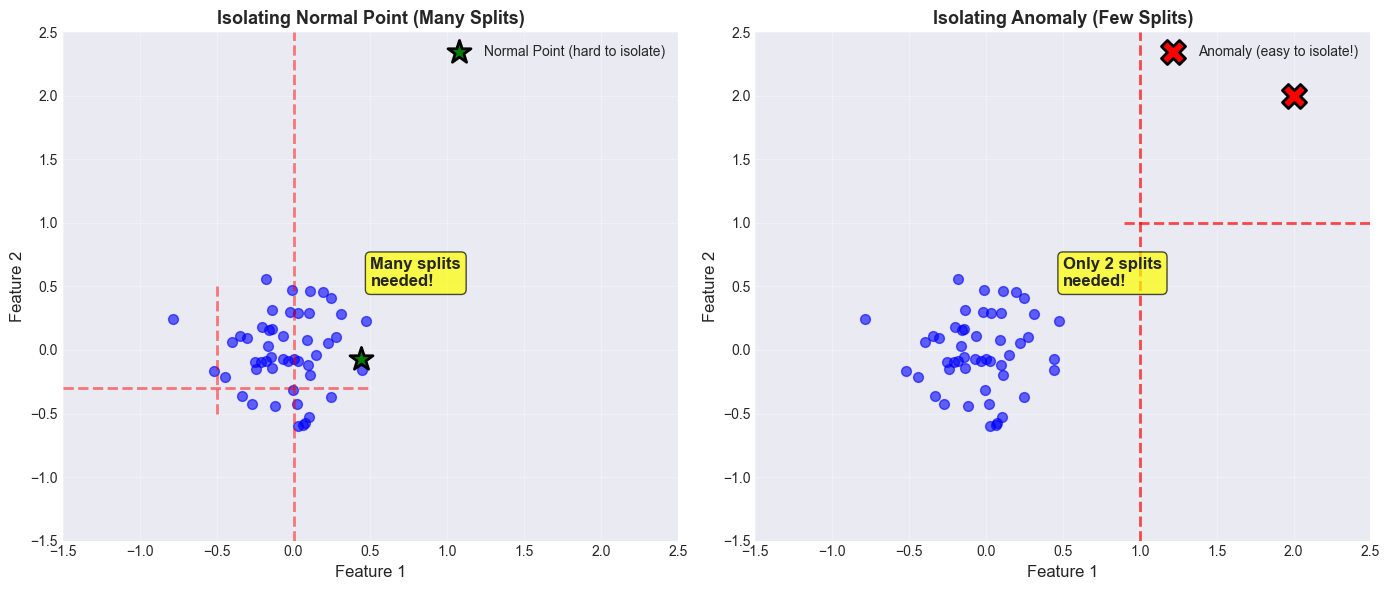


💡 Key Insight: Anomalies require fewer splits to isolate!
   Shorter path length → More anomalous


In [6]:
# Demonstrate isolation concept
np.random.seed(42)

# Simple example: normal cluster + 1 anomaly
X_demo = np.random.randn(50, 2) * 0.3
anomaly_point = np.array([[2, 2]])
X_demo_full = np.vstack([X_demo, anomaly_point])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Normal point isolation
normal_idx = 10
axes[0].scatter(X_demo[:, 0], X_demo[:, 1], c='blue', s=50, alpha=0.6)
axes[0].scatter(X_demo[normal_idx, 0], X_demo[normal_idx, 1], 
               c='green', s=300, marker='*', edgecolors='black', linewidth=2,
               label='Normal Point (hard to isolate)', zorder=5)
# Draw example splits
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0].axhline(-0.3, color='red', linestyle='--', linewidth=2, alpha=0.5, xmax=0.5)
axes[0].axvline(-0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, ymin=0.25, ymax=0.5)
axes[0].text(0.5, 0.5, 'Many splits\nneeded!', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Isolating Normal Point (Many Splits)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-1.5, 2.5)
axes[0].set_ylim(-1.5, 2.5)

# Anomaly isolation
axes[1].scatter(X_demo[:, 0], X_demo[:, 1], c='blue', s=50, alpha=0.6)
axes[1].scatter(anomaly_point[0, 0], anomaly_point[0, 1],
               c='red', s=300, marker='X', edgecolors='black', linewidth=2,
               label='Anomaly (easy to isolate!)', zorder=5)
# Draw splits isolating anomaly
axes[1].axvline(1, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1].axhline(1, color='red', linestyle='--', linewidth=2, alpha=0.7, xmin=0.6)
axes[1].text(0.5, 0.5, 'Only 2 splits\nneeded!', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('Isolating Anomaly (Few Splits)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-1.5, 2.5)
axes[1].set_ylim(-1.5, 2.5)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Anomalies require fewer splits to isolate!")
print("   Shorter path length → More anomalous")

## 5. Comparing Methods

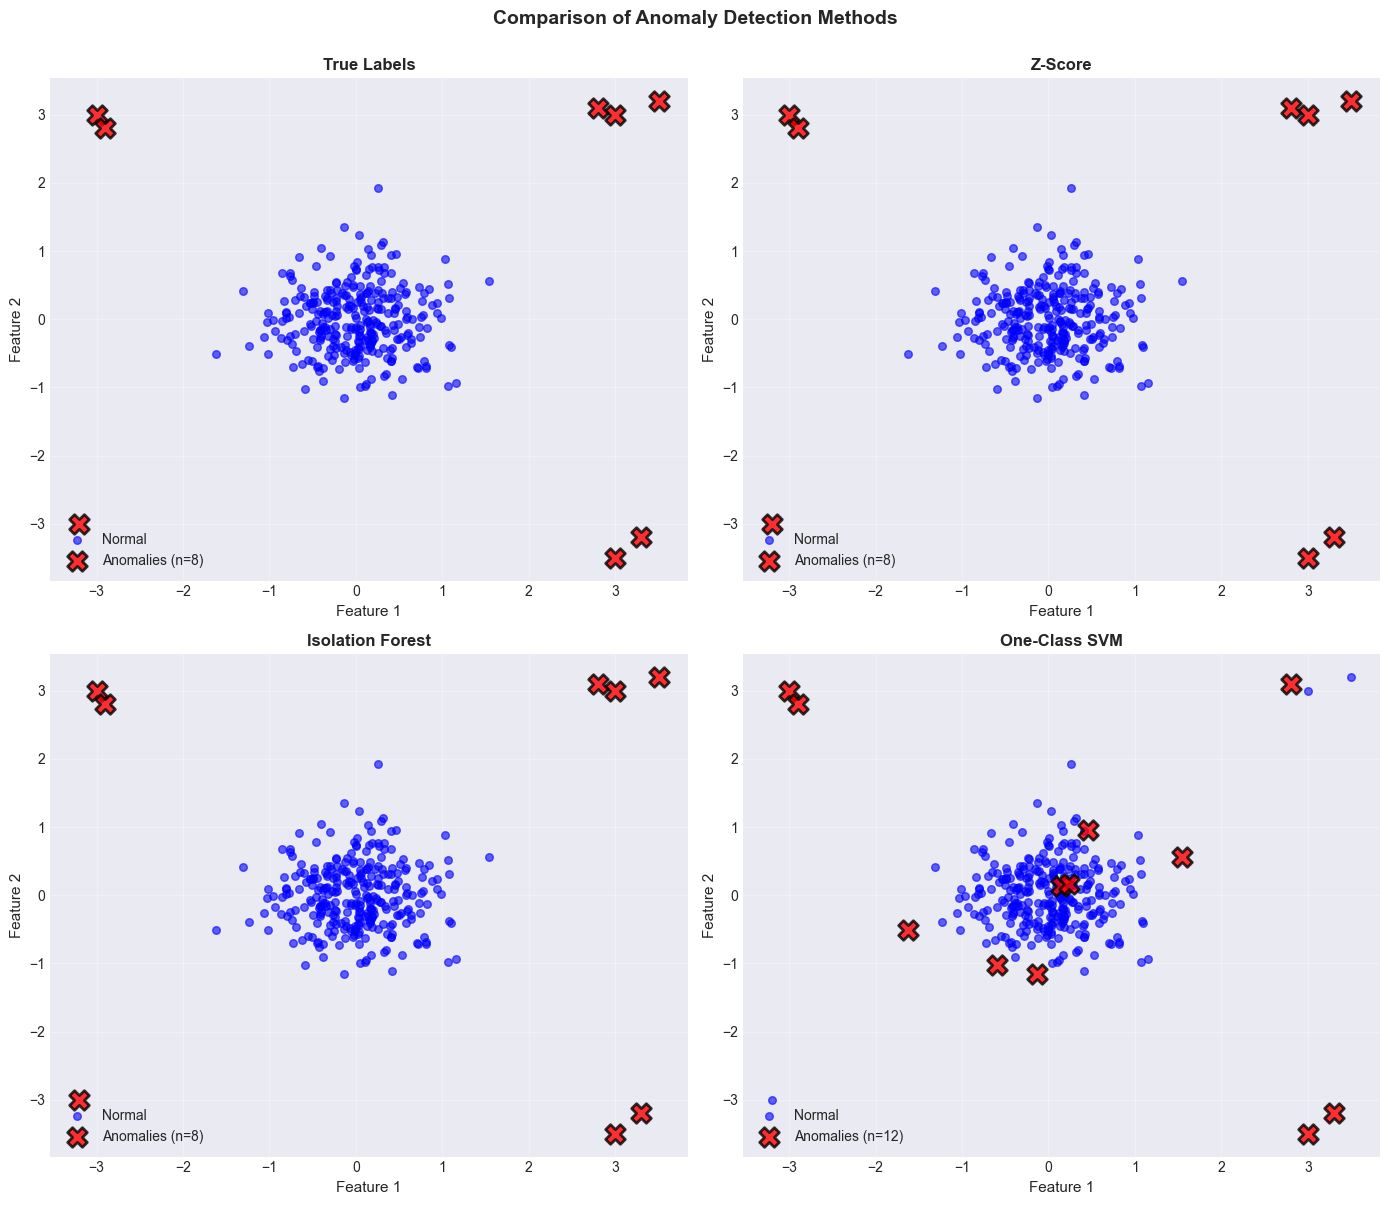


📊 Method Comparison:

True anomalies: 8

Detected anomalies:
  Z-Score: 8 (Correct: 8)
  Isolation Forest: 8 (Correct: 8)
  One-Class SVM: 12 (Correct: 5)


In [7]:
# Compare all three methods on same data
# Method 1: Z-Score (per feature)
z_scores_feat = np.abs(stats.zscore(X_combined_scaled))
y_pred_zscore = ((z_scores_feat > 3).any(axis=1)).astype(int)

# Method 2: Isolation Forest
iso_pred = iso_forest.fit_predict(X_combined_scaled)
y_pred_iso = (iso_pred == -1).astype(int)

# Method 3: One-Class SVM
ocsvm = OneClassSVM(nu=len(X_anomalies)/len(X_combined), kernel='rbf', gamma='auto')
ocsvm_pred = ocsvm.fit_predict(X_combined_scaled)
y_pred_ocsvm = (ocsvm_pred == -1).astype(int)

# Visualize all methods
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

methods = [
    ('True Labels', y_true),
    ('Z-Score', y_pred_zscore),
    ('Isolation Forest', y_pred_iso),
    ('One-Class SVM', y_pred_ocsvm)
]

for ax, (method_name, y_pred_method) in zip(axes.flat, methods):
    # Plot normal points
    ax.scatter(X_combined[y_pred_method==0, 0], X_combined[y_pred_method==0, 1],
              c='blue', s=30, alpha=0.6, label='Normal')
    # Plot anomalies
    ax.scatter(X_combined[y_pred_method==1, 0], X_combined[y_pred_method==1, 1],
              c='red', s=200, alpha=0.8, marker='X', edgecolors='black', linewidth=2,
              label=f'Anomalies (n={sum(y_pred_method)})')
    
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.set_title(method_name, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison of Anomaly Detection Methods', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# Compare performance
print("\n📊 Method Comparison:")
print(f"\nTrue anomalies: {sum(y_true)}")
print(f"\nDetected anomalies:")
print(f"  Z-Score: {sum(y_pred_zscore)} (Correct: {sum((y_true==1) & (y_pred_zscore==1))})")
print(f"  Isolation Forest: {sum(y_pred_iso)} (Correct: {sum((y_true==1) & (y_pred_iso==1))})")
print(f"  One-Class SVM: {sum(y_pred_ocsvm)} (Correct: {sum((y_true==1) & (y_pred_ocsvm==1))})")

## 6. Real-World Example: Credit Card Fraud Detection

Simulate credit card transactions with fraudulent activities:

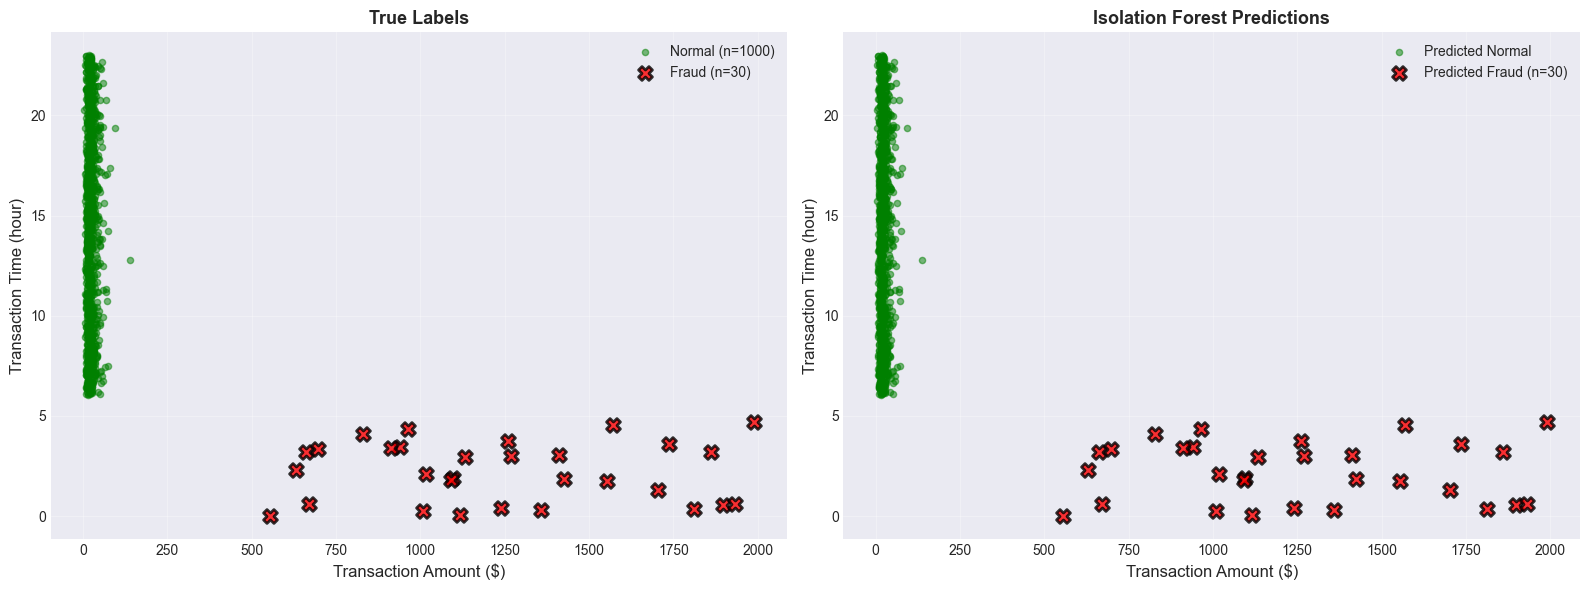


📊 Fraud Detection Results:

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%

🎯 Business Impact:
  ✓ Caught fraud: 30/30 (100.0%)
  ✗ Missed fraud: 0
  ⚠️  False alarms: 0


In [8]:
# Simulate credit card transactions
np.random.seed(42)

# Normal transactions
n_normal = 1000
transaction_amounts_normal = np.random.lognormal(3, 0.5, n_normal)  # Mean ~$20-50
transaction_times_normal = np.random.uniform(6, 23, n_normal)  # 6am - 11pm

# Fraudulent transactions
n_fraud = 30
transaction_amounts_fraud = np.random.uniform(500, 2000, n_fraud)  # Large amounts
transaction_times_fraud = np.random.uniform(0, 5, n_fraud)  # Late night

# Combine
X_transactions = np.vstack([
    np.column_stack([transaction_amounts_normal, transaction_times_normal]),
    np.column_stack([transaction_amounts_fraud, transaction_times_fraud])
])
y_fraud = np.array([0]*n_normal + [1]*n_fraud)

# Scale features
scaler_trans = StandardScaler()
X_trans_scaled = scaler_trans.fit_transform(X_transactions)

# Apply Isolation Forest
iso_forest_fraud = IsolationForest(contamination=n_fraud/len(X_transactions),
                                    random_state=42)
y_pred_fraud = iso_forest_fraud.fit_predict(X_trans_scaled)
y_pred_fraud_binary = (y_pred_fraud == -1).astype(int)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True labels
axes[0].scatter(X_transactions[y_fraud==0, 0], X_transactions[y_fraud==0, 1],
               c='green', s=20, alpha=0.5, label=f'Normal (n={n_normal})')
axes[0].scatter(X_transactions[y_fraud==1, 0], X_transactions[y_fraud==1, 1],
               c='red', s=100, alpha=0.8, marker='X', edgecolors='black', linewidth=2,
               label=f'Fraud (n={n_fraud})')
axes[0].set_xlabel('Transaction Amount ($)', fontsize=12)
axes[0].set_ylabel('Transaction Time (hour)', fontsize=12)
axes[0].set_title('True Labels', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions
axes[1].scatter(X_transactions[y_pred_fraud_binary==0, 0], 
               X_transactions[y_pred_fraud_binary==0, 1],
               c='green', s=20, alpha=0.5, label='Predicted Normal')
axes[1].scatter(X_transactions[y_pred_fraud_binary==1, 0], 
               X_transactions[y_pred_fraud_binary==1, 1],
               c='red', s=100, alpha=0.8, marker='X', edgecolors='black', linewidth=2,
               label=f'Predicted Fraud (n={sum(y_pred_fraud_binary)})')
axes[1].set_xlabel('Transaction Amount ($)', fontsize=12)
axes[1].set_ylabel('Transaction Time (hour)', fontsize=12)
axes[1].set_title('Isolation Forest Predictions', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n📊 Fraud Detection Results:")
print(f"\nAccuracy: {accuracy_score(y_fraud, y_pred_fraud_binary):.2%}")
print(f"Precision: {precision_score(y_fraud, y_pred_fraud_binary):.2%}")
print(f"Recall: {recall_score(y_fraud, y_pred_fraud_binary):.2%}")
print(f"F1-Score: {f1_score(y_fraud, y_pred_fraud_binary):.2%}")

print(f"\n🎯 Business Impact:")
true_positives = sum((y_fraud==1) & (y_pred_fraud_binary==1))
false_positives = sum((y_fraud==0) & (y_pred_fraud_binary==1))
false_negatives = sum((y_fraud==1) & (y_pred_fraud_binary==0))
print(f"  ✓ Caught fraud: {true_positives}/{n_fraud} ({true_positives/n_fraud:.1%})")
print(f"  ✗ Missed fraud: {false_negatives}")
print(f"  ⚠️  False alarms: {false_positives}")

## 7. Evaluation Challenges

### The Problem

Often we **don't have labeled anomalies** for evaluation!

### Strategies

1. **With labels:**
   - Precision, Recall, F1-score
   - ROC-AUC, PR-AUC
   - Confusion matrix

2. **Without labels:**
   - Domain expert review
   - Business metrics (e.g., fraud caught)
   - A/B testing
   - Manual inspection of top anomalies

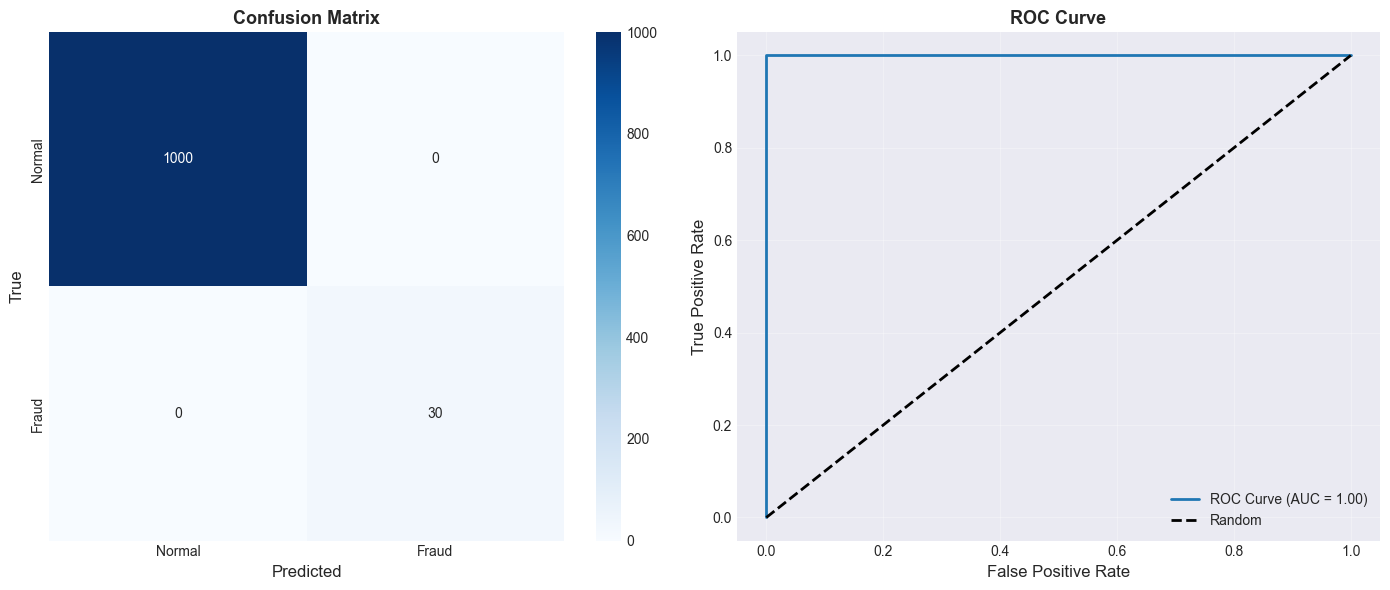


📊 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
       Fraud       1.00      1.00      1.00        30

    accuracy                           1.00      1030
   macro avg       1.00      1.00      1.00      1030
weighted avg       1.00      1.00      1.00      1030



In [9]:
# Evaluation with labels
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_fraud, y_pred_fraud_binary)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['Normal', 'Fraud'],
           yticklabels=['Normal', 'Fraud'])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
axes[0].set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# ROC curve
scores_fraud = iso_forest_fraud.decision_function(X_trans_scaled)
fpr, tpr, _ = roc_curve(y_fraud, -scores_fraud)  # Negative because lower score = anomaly
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Classification Report:")
print(classification_report(y_fraud, y_pred_fraud_binary,
                          target_names=['Normal', 'Fraud']))

## 8. Practical Guidelines

### Method Selection

| Method | Best For | Assumptions | Speed |
|--------|----------|-------------|-------|
| **Z-Score** | Univariate, normal data | Normal distribution | Very fast |
| **IQR** | Univariate, any distribution | None | Very fast |
| **Isolation Forest** | Multivariate, complex patterns | None | Fast |
| **One-Class SVM** | Non-linear boundaries | None | Slower |

### Do's ✓

1. **Scale features** before applying Isolation Forest
2. **Set contamination** based on domain knowledge
3. **Validate results** with domain experts
4. **Try multiple methods** and compare
5. **Monitor over time** (anomalies change!)

### Don'ts ✗

1. **Don't blindly trust** automated detection
2. **Don't ignore false positives** (they erode trust)
3. **Don't use Z-score on non-normal data**
4. **Don't forget class imbalance** (anomalies are rare!)
5. **Don't neglect cost** of false positives vs false negatives

## 9. Cost-Sensitive Anomaly Detection

**Reality:** Not all errors are equal!

- **False Negative (missed fraud):** Lose money, customer trust
- **False Positive (false alarm):** Annoy customer, manual review cost

**Solution:** Adjust threshold based on costs

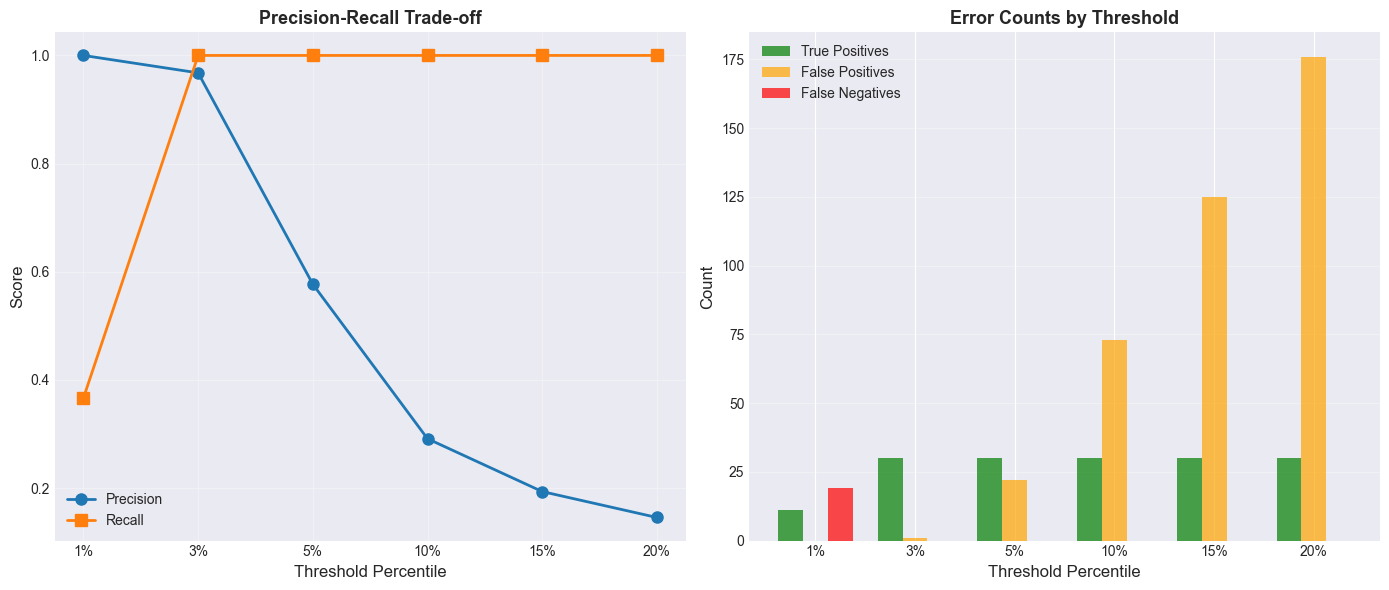


📊 Threshold Analysis:
 threshold  detected  precision   recall  tp  fp  fn
 -0.087009        11   1.000000 0.366667  11   0  19
  0.014852        31   0.967742 1.000000  30   1   0
  0.102341        52   0.576923 1.000000  30  22   0
  0.155724       103   0.291262 1.000000  30  73   0
  0.176056       155   0.193548 1.000000  30 125   0
  0.190434       206   0.145631 1.000000  30 176   0

💡 Choose threshold based on business costs!
   Lower threshold → More detections, higher false positive rate
   Higher threshold → Fewer detections, lower false positive rate


In [10]:
# Explore threshold trade-offs
# Get anomaly scores
scores = iso_forest_fraud.decision_function(X_trans_scaled)

# Try different thresholds
thresholds = np.percentile(scores, [1, 3, 5, 10, 15, 20])

results = []
for thresh in thresholds:
    y_pred_thresh = (scores < thresh).astype(int)
    tp = sum((y_fraud==1) & (y_pred_thresh==1))
    fp = sum((y_fraud==0) & (y_pred_thresh==1))
    fn = sum((y_fraud==1) & (y_pred_thresh==0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    results.append({
        'threshold': thresh,
        'detected': sum(y_pred_thresh),
        'precision': precision,
        'recall': recall,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

results_df = pd.DataFrame(results)

# Visualize trade-offs
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precision-Recall trade-off
axes[0].plot(results_df.index, results_df['precision'], 'o-', linewidth=2, markersize=8,
            label='Precision')
axes[0].plot(results_df.index, results_df['recall'], 's-', linewidth=2, markersize=8,
            label='Recall')
axes[0].set_xlabel('Threshold Percentile', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Precision-Recall Trade-off', fontsize=13, fontweight='bold')
axes[0].set_xticks(results_df.index)
axes[0].set_xticklabels(['1%', '3%', '5%', '10%', '15%', '20%'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# TP, FP, FN counts
x = np.arange(len(results_df))
width = 0.25
axes[1].bar(x - width, results_df['tp'], width, label='True Positives', color='green', alpha=0.7)
axes[1].bar(x, results_df['fp'], width, label='False Positives', color='orange', alpha=0.7)
axes[1].bar(x + width, results_df['fn'], width, label='False Negatives', color='red', alpha=0.7)
axes[1].set_xlabel('Threshold Percentile', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Error Counts by Threshold', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['1%', '3%', '5%', '10%', '15%', '20%'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Threshold Analysis:")
print(results_df.to_string(index=False))
print("\n💡 Choose threshold based on business costs!")
print("   Lower threshold → More detections, higher false positive rate")
print("   Higher threshold → Fewer detections, lower false positive rate")

## Summary

### Key Takeaways

1. **Anomalies** are unusual data points that deviate from normal patterns

2. **Statistical methods** (Z-score, IQR) are simple but assume distributions

3. **Isolation Forest** is powerful, scalable, and makes no assumptions

4. **Always scale features** before Isolation Forest

5. **Evaluation is challenging** without labels

6. **Business context matters** for threshold selection

### When to Use What

**Use Z-Score/IQR when:**
- Univariate data
- Simple, interpretable method needed
- Fast computation required

**Use Isolation Forest when:**
- Multivariate data
- Complex patterns
- No distribution assumptions
- Scalability needed

**Use One-Class SVM when:**
- Non-linear boundaries
- Smaller datasets
- High accuracy needed

### Practical Workflow

```
1. Understand domain (what is "normal"?)
2. Scale features
3. Set contamination based on domain knowledge
4. Apply Isolation Forest
5. Validate with experts
6. Adjust threshold based on costs
7. Monitor and update regularly
```

## Course Conclusion

Congratulations! You've completed Week 6 on **Unsupervised Learning**!

### What We Covered

1. **Clustering:** K-means, Hierarchical, DBSCAN
2. **Dimensionality Reduction:** PCA, UMAP
3. **Anomaly Detection:** Statistical methods, Isolation Forest

### Key Skills Acquired

✅ Find structure in unlabeled data

✅ Visualize high-dimensional data

✅ Detect outliers and anomalies

✅ Choose appropriate methods

✅ Evaluate results without ground truth

### Next Steps

Apply these techniques to your projects and datasets!

**Practice in the lab exercises!**